In [557]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import tqdm as notebook_tqdm
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [558]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')  # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})  # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

In [559]:
train = pd.read_csv('../../.././data/train.csv')
test  = pd.read_csv('../../.././data/test.csv')
address  = pd.read_csv('../../.././data/addresses.csv')

In [560]:
train['계약년'] = train['계약년월'].astype(str).str[:4].astype(int)

In [561]:
test['계약년'] = test['계약년월'].astype(str).str[:4].astype(int)

In [562]:
train = train[train['계약년']>=2018]

In [563]:
train.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '계약년'],
      dtype='object')

In [564]:
# 범주형 컬럼 자동 탐지 + 명시적 범주형 포함
auto_cats = train.select_dtypes(include=['object', 'category']).columns.tolist()
explicit_cats = ['연식_bin', '층구간_상대', '브랜드', '아파트명', '도로명', '주소', '구', '동', 'area_bin_in_region']
cat_cols = [c for c in (set(auto_cats) | set(explicit_cats)) if c in train.columns]

In [565]:
# Train/Test 합쳐 카테고리 정합
if len(cat_cols) > 0:
    concat = pd.concat([train[cat_cols], test[cat_cols]], axis=0, ignore_index=True)
    for c in cat_cols:
        concat[c] = concat[c].astype('category')
    for c in cat_cols:
        train[c] = pd.Categorical(train[c], categories=concat[c].cat.categories)
        test[c]  = pd.Categorical(test[c],  categories=concat[c].cat.categories)

In [566]:
# 피처/타깃 분리 (is_test는 정보량이 없으므로 제거)
drop_cols = []
if 'is_test' in train.columns:
    drop_cols.append('is_test')

In [567]:
train.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '계약년'],
      dtype='object')

In [568]:
train.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', '계약년'],
      dtype='object')

In [569]:
for c in list(train.columns):
    if train[c].isna().sum() >= (len(train)*0.5):
        drop_cols.append(c)

In [570]:
drop_cols.append('target')

In [571]:
X = train.drop(columns=drop_cols)
y = train['target'].astype(float)
X_test = test.drop(columns=['is_test']) if 'is_test' in test.columns else test.copy()

In [572]:
X.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '등기신청일자', '거래유형', '중개사소재지', '계약년'],
      dtype='object')

In [573]:
train[X.columns]

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,계약년
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,언주로 3,,-,-,2018
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,언주로 3,,-,-,2018
5,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,11,1,1987,언주로 3,,-,-,2018
6,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201803,19,2,1987,언주로 3,,-,-,2018
7,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201804,5,5,1987,언주로 3,,-,-,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600089,서울특별시 종로구 숭인동,2-1,2.0,1.0,종로센트레빌,59.92,201908,26,8,2008,동망산길 47,,-,-,2019
600090,서울특별시 종로구 숭인동,2-1,2.0,1.0,종로센트레빌,59.92,201909,4,7,2008,동망산길 47,,-,-,2019
600091,서울특별시 종로구 숭인동,2-1,2.0,1.0,종로센트레빌,59.92,201909,26,7,2008,동망산길 47,,-,-,2019
600092,서울특별시 중구 묵정동,11-67,11.0,67.0,묵정,52.46,201810,14,9,1981,서애로1길 34,,-,-,2018


In [574]:
categorical_feature = cat_cols
print(f"[INFO] 사용 범주형 컬럼: {categorical_feature}")
print(f"[INFO] X.shape={X.shape}, X_test.shape={X_test.shape}")

[INFO] 사용 범주형 컬럼: ['시군구', '청소비관리형태', 'k-사용검사일-사용승인일', '중개사소재지', 'k-홈페이지', 'k-시행사', '거래유형', '번지', '등기신청일자', 'k-난방방식', '단지신청일', '아파트명', '기타/의무/임대/임의=1/2/3/4', 'k-복도유형', '관리비 업로드', '도로명', 'k-건설사(시공사)', 'k-수정일자', '경비비관리형태', '세대전기계약방법', 'k-전화번호', '단지승인일', '사용허가여부', 'k-관리방식', 'k-세대타입(분양형태)', 'k-팩스번호', '고용보험관리번호', 'k-등록일자', 'k-단지분류(아파트,주상복합등등)']
[INFO] X.shape=(312699, 15), X_test.shape=(9272, 52)


In [575]:
# K-Fold 설정
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)

# 베스트 폴드 단일 모델만 선택
best_model = None
best_fold = None
best_fold_rmse = np.inf
best_iteration = None

# 충분히 큰 반복 + Early Stopping
base_params = dict(
    random_state=2023,
    n_estimators=10000
)

oof_pred_log = np.zeros(len(X))
fold_rmses = []

In [576]:
train

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,계약년
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000,2018
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,117000,2018
5,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,11,1,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000,2018
6,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201803,19,2,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,139500,2018
7,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201804,5,5,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,107500,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600089,서울특별시 종로구 숭인동,2-1,2.0,1.0,종로센트레빌,59.92,201908,26,8,2008,...,512.0,의무,2017-06-05 10:14:04.0,Y,N,127.015931,37.580983,2013-03-07 09:46:38.0,66800,2019
600090,서울특별시 종로구 숭인동,2-1,2.0,1.0,종로센트레빌,59.92,201909,4,7,2008,...,512.0,의무,2017-06-05 10:14:04.0,Y,N,127.015931,37.580983,2013-03-07 09:46:38.0,67000,2019
600091,서울특별시 종로구 숭인동,2-1,2.0,1.0,종로센트레빌,59.92,201909,26,7,2008,...,512.0,의무,2017-06-05 10:14:04.0,Y,N,127.015931,37.580983,2013-03-07 09:46:38.0,65000,2019
600092,서울특별시 중구 묵정동,11-67,11.0,67.0,묵정,52.46,201810,14,9,1981,...,45.0,임의,2020-07-10 00:00:00.0,Y,Y,127.000071,37.560706,2017-09-05 20:06:39.0,32000,2018


In [577]:
boosting_types = ['gbdt', 'goss','dart']  # 사용할 boosting type
oof_pred = np.zeros(len(X))
fold_rmses = []

best_fold_rmse = np.inf
best_fold = None
best_model_list = []

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y), start=1):
    print(f"[KFold] Fold {fold}/{n_splits} 학습 중...")
    X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_trn, y_val = y.iloc[trn_idx], y.iloc[val_idx]

    val_preds_fold = []  # Fold별 boosting_type 예측 저장

    for boost in boosting_types:
        model = lgb.LGBMRegressor(**base_params, boosting_type=boost)
        model.fit(
            X_trn, y_trn,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
        )

        val_pred = model.predict(X_val, num_iteration=model.best_iteration_)
        val_preds_fold.append(val_pred)

        # 베스트 모델 저장 (예시: GBDT 기준)
        if boost == 'gbdt' and np.sqrt(mean_squared_error(y_val.values, val_pred)) < best_fold_rmse:
            best_fold_rmse = np.sqrt(mean_squared_error(y_val.values, val_pred))
            best_fold = fold
            total_best_model_list = [model]  # 베스트 모델 리스트 저장

    # Fold별 boosting_type 예측 평균 → OOF에 저장
    oof_pred[val_idx] = np.mean(val_preds_fold, axis=0)

    # Fold RMSE (원스케일)
    rmse_fold = np.sqrt(mean_squared_error(y_val.values, oof_pred[val_idx]))
    fold_rmses.append(rmse_fold)
    print(f"[KFold] Fold {fold} RMSE(orig, 앙상블) = {rmse_fold:,.5f}")

[KFold] Fold 1/5 학습 중...
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16480
[LightGBM] [Info] Number of data points in the train set: 250159, number of used features: 15
[LightGBM] [Info] Start training from score 83534.509508


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16480
[LightGBM] [Info] Number of data points in the train set: 250159, number of used f

In [578]:
X_text = test[X.columns]

In [579]:
best_model = total_best_model_list[0]
test_pred = best_model.predict(X_text)

In [580]:
test_pred

array([175678.70440545, 284522.07369356, 356803.01168511, ...,
        87328.17303279,  71206.8954492 ,  63772.39952159])

In [581]:
test_pred = test_pred.astype(int)

In [582]:
# 저장
sub_path = 'lgbm_kfold_boostingtype_2018_ensemble_preds.csv'
pd.DataFrame({'target': test_pred}).to_csv(sub_path, index=False)
print(f"[SAVE] {sub_path} 저장 완료")

[SAVE] lgbm_kfold_boostingtype_2018_ensemble_preds.csv 저장 완료


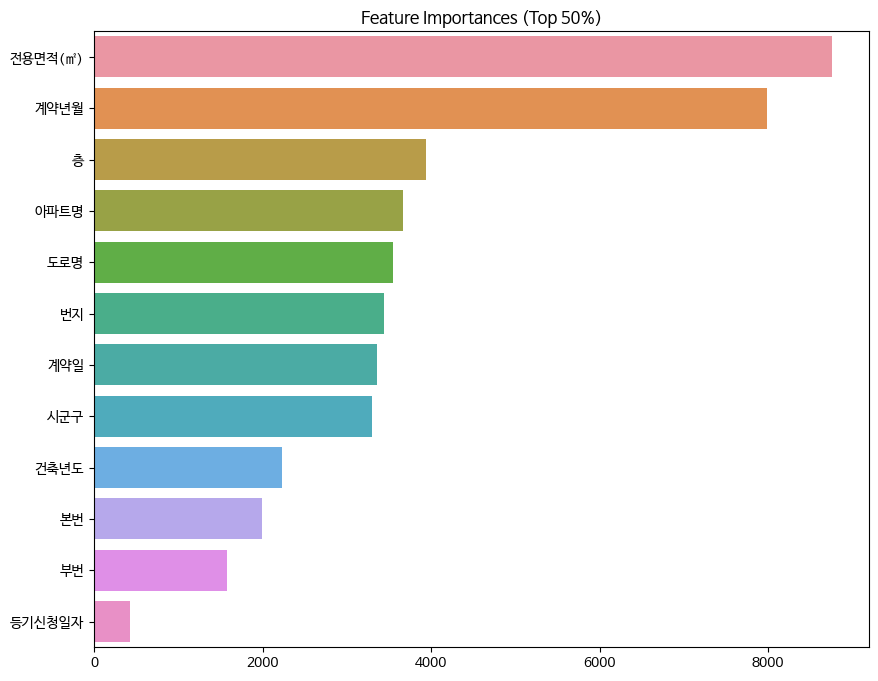

In [583]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X.columns))
importances = importances.sort_values(ascending=False)

# 상위 50%만 선택
top_n = max(1, int(np.ceil(len(importances) * 0.8)))
importances = importances.iloc[:top_n]

plt.figure(figsize=(10, 8))
plt.title("Feature Importances (Top 50%)")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [584]:
X.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '등기신청일자', '거래유형', '중개사소재지', '계약년'],
      dtype='object')